In [143]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rc('font', family='Hancom Gothic')
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# KOSPI200 불러오기 & 데이터셋 생성

In [144]:
import pickle
with open('raw_data_20180811.pickle','rb') as handle:

    raw_data = pickle.load(handle)
    
kospi200 = pd.read_excel("C:\\Users\\axasd\\Downloads\\상장법인목록.xlsx")
kospi200 = kospi200[kospi200.columns[:2]]
kospi200["종목코드"] = kospi200["종목코드"].map('{:06d}'.format)

code_dict = {
    i : j for i, j in zip(kospi200["회사명"], kospi200["종목코드"])
}

In [145]:
for i in raw_data.keys():
    raw_data[i] = raw_data[i].assign(sum_close_7 = raw_data[i].Close.rolling(window =7).sum())
    raw_data[i] = raw_data[i].assign(ma_3 = raw_data[i].Close.rolling(window = 3).mean())
    raw_data[i] = raw_data[i].assign(ma_5 = raw_data[i].Close.rolling(window = 5).mean())
    raw_data[i] = raw_data[i].assign(ma_10 = raw_data[i].Close.rolling(window = 10).mean())
    raw_data[i] = raw_data[i].assign(ma_15 = raw_data[i].Close.rolling(window = 15).mean())

for i in raw_data.keys():
    raw_data[i] = raw_data[i].assign(pct_change7 = raw_data[i].sum_close_7.pct_change().fillna(0))
    raw_data[i] = raw_data[i].assign(sum_7_Y = np.where(raw_data[i]["pct_change7"].fillna(0)>=0, 1,0))
    
for i in raw_data.keys():
    raw_data[i] = raw_data[i].dropna(axis=0)

In [146]:
copy_keys = kospi200["종목코드"]
for i in copy_keys:
    if (len(raw_data[i]) < 252):
        del raw_data[i]

# 데이터 셋 : oepn, MA3, MA5, MA10
# Y : 7일 종가 평균 등락

### Train, Test Split

In [147]:
train6 = {}
train_idx6 = {}
test6 = {}
test_idx6 = {}
for code, df in raw_data.items():
    train6[code] = df.iloc[:int(len(df)*0.8)][["Open","ma_3","ma_5", "ma_10"]]
    train_idx6[code] = df.iloc[:int(len(df)*0.8)]["sum_7_Y"]
    test6[code] = df.iloc[int(len(df)*0.8):][["Open","ma_3","ma_5", "ma_10"]]
    test_idx6[code] = df.iloc[int(len(df)*0.8):]["sum_7_Y"]

### Scale 조정

In [148]:
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
li6 = ["Open","ma_3","ma_5", "ma_10"]
for code in raw_data.keys():
    train6[code][li6] = std_scaler.fit_transform(train6[code][li6].values)
    test6[code][li6] = std_scaler.fit_transform(test6[code][li6].values)

### model 호출

In [149]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

log_clf = LogisticRegression()
DTC_clf = DecisionTreeClassifier()
svm_clf = SVC()

### Predict

In [150]:
from sklearn.metrics import accuracy_score

score_list6 = pd.DataFrame(columns=('LR','DT','SVM'))


for i in raw_data.keys():
    a6=[]
    X_train6 = train6[i].values
    y_train6 = train_idx6[i].values
    X_test6 = test6[i].values
    y_test6 = test_idx6[i].values
    for clf in (log_clf, DTC_clf, svm_clf):
        clf.fit(X_train6, y_train6)
        y_pred6 = clf.predict(X_test6)
        a6.append(accuracy_score(y_test6, y_pred6))
    score_list6.loc[i] = a6

In [151]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

CM = pd.DataFrame(columns=('LR','DT','SVM'))
roc_auc_score = pd.DataFrame(columns=('LR','SVM','DT'))
y_train_5 = np.array([])
y_scores1 = np.array([])
y_scores2 = np.array([])
y_scores3 = np.array([])

for i in raw_data.keys():
    b1=[]
    b2=[]
    X_train = train6[i].values
    y_train = train_idx6[i].values
    X_test = test6[i].values
    y_test = test_idx6[i].values
    score1=cross_val_predict(log_clf, X_train, y_train, cv=3,method="decision_function")
    score2=cross_val_predict(svm_clf, X_train, y_train, cv=3,method="decision_function")
    score3=cross_val_predict(DTC_clf, X_train, y_train, cv=3,method="predict_proba")
    fpr, tpr, thresholds = roc_curve(y_train, score1)
    b2.append([auc(fpr, tpr)])
    fpr, tpr, thresholds = roc_curve(y_train, score2)
    b2.append([auc(fpr, tpr)])
    fpr, tpr, thresholds = roc_curve(y_train, score3[:,1])
    b2.append([auc(fpr, tpr)])
    for clf in (log_clf, DTC_clf, svm_clf):
        y_train_pred = cross_val_predict(clf, X_train, y_train, cv=3)
        b1.append([confusion_matrix(y_train, y_train_pred)])
    CM.loc[i] = b1
    roc_auc_score.loc[i] = b2
    y_train_5 = np.concatenate((y_train_5,y_train),axis=0)
    y_scores1 = np.concatenate((y_scores1,score1),axis=0)
    y_scores2 = np.concatenate((y_scores2,score2),axis=0)
    y_scores3 = np.concatenate((y_scores3,score3[:,1]),axis=0)

In [164]:
score_list6.describe()

,LR,DT,SVM
count,197.000000,197.000000,197.000000
mean,0.838209,0.771013,0.792577
std,0.055249,0.059442,0.081751
min,0.428571,0.354037,0.411765
25%,0.822981,0.745342,0.763975
50%,0.847826,0.779503,0.813665
75%,0.866460,0.807453,0.847826
max,0.916149,0.878882,0.913043


In [152]:
print(score_list6['LR'].argmax())
print(score_list6['LR'].argmin())

000670
042660


c:\users\axasd\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  """Entry point for launching an IPython kernel.
c:\users\axasd\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.
  


In [153]:
score_list6.ix["000670"]

c:\users\axasd\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


LR     0.916149
DT     0.810559
SVM    0.900621
Name: 000670, dtype: float64

In [154]:
score_list6.ix["042660"]

c:\users\axasd\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


LR     0.428571
DT     0.354037
SVM    0.701863
Name: 042660, dtype: float64

## score 최고 종목 : 영풍(000670)

## 정밀도 : 0.86, 0.68, 0.81  재현율 : 0.85, 0.75, 0.75

In [87]:
from sklearn.metrics import f1_score

X_train_YP = train6["000670"].values
y_train_YP = train_idx6["000670"].values
for clf in (log_clf, DTC_clf, svm_clf):
    y_train_pred_YP = cross_val_predict(clf, X_train_YP, y_train_YP, cv=3)
    print(f1_score(y_train_YP,y_train_pred_YP))

0.8595178719866998
0.7110055423594616
0.7771135781383434


In [79]:
print(CM['LR']['000670'])
print(CM['DT']['000670'])
print(CM['SVM']['000670'])

[array([[598,  78],
       [ 91, 517]], dtype=int64)]
[array([[462, 214],
       [153, 455]], dtype=int64)]
[array([[568, 108],
       [153, 455]], dtype=int64)]


In [80]:
print(roc_auc_score['LR']['000670'])
print(roc_auc_score['DT']['000670'])
print(roc_auc_score['SVM']['000670'])

[0.9510131189660542]
[0.7156454375583929]
[0.886123871068203]


## score 최저 종목 : 대우조선해양(042660)

## 정밀도 : 0.75, 0.65, 0.58  재현율 : 0.87, 0.65, 0.47

In [85]:
from sklearn.metrics import f1_score

X_train_DW = train6["042660"].values
y_train_DW = train_idx6["042660"].values
for clf in (log_clf, DTC_clf, svm_clf):
    y_train_pred_DW = cross_val_predict(clf, X_train_DW, y_train_DW, cv=3)
    print(f1_score(y_train_DW,y_train_pred_DW))

0.8046607265250171
0.6299093655589124
0.5185185185185185


In [50]:
print(CM['LR']['042660'])
print(CM['DT']['042660'])
print(CM['SVM']['042660'])

[array([[412, 201],
       [ 84, 587]], dtype=int64)]
[array([[380, 233],
       [234, 437]], dtype=int64)]
[array([[384, 229],
       [356, 315]], dtype=int64)]


In [64]:
print(roc_auc_score['LR']['042660'])
print(roc_auc_score['DT']['042660'])
print(roc_auc_score['SVM']['042660'])

[0.8402690829348226]
[0.6058486882571604]
[0.5878834881589408]


## 코스피200 전체 confusion matrix

## 정밀도 : 0.81, 0.67,0.67   재현율 : 0.83, 0.64, 0.66  F1 : 0.82, 0.66, 0.67

In [86]:
sum_CM1 = np.zeros((2, 2))
sum_CM2 = np.zeros((2, 2))
sum_CM3 = np.zeros((2, 2))

for i in raw_data.keys():
    sum_CM1 = sum(sum_CM1,CM['LR'].ix[i])

for i in raw_data.keys():
    sum_CM2 = sum(sum_CM2,CM['DT'].ix[i])
    
for i in raw_data.keys():
    sum_CM3 = sum(sum_CM3,CM['SVM'].ix[i])
    
print(sum_CM1)
print(sum_CM2)
print(sum_CM3)

[[[ 97120.  23109.]
  [ 21353. 101493.]]]
[[[80843. 39386.]
  [43716. 79130.]]]
[[[80359. 39870.]
  [42221. 80625.]]]


c:\users\axasd\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  
c:\users\axasd\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  if __name__ == '__main__':
c:\users\axasd\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecate

In [53]:
KOSPI_len=[]
for i in raw_data.keys():
    KOSPI_len.append(len(raw_data[i]))
    
print(int(sum(KOSPI_len)*0.8))
print(np.sum(sum_CM))

#코스피200 row 확인 (traind이라 24만개)

243226
243075.0


## 결정 임곗값에 대한 정밀도와 재현율

In [54]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores1)

In [55]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="정밀도", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="재현율", linewidth=2)
    plt.xlabel("임계값", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])

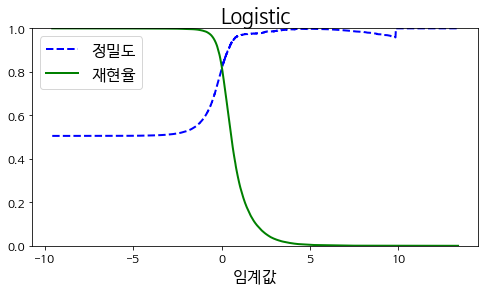

In [66]:
#코스피200 전체 결정경계(로지스틱)
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores1)
plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.title('Logistic',fontsize=20)
plt.show()

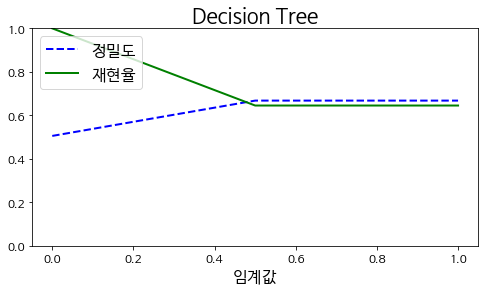

In [161]:
#코스피200 전체 결정경계(디시전트리)
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores3)
plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.title('Decision Tree',fontsize=20)
plt.show()

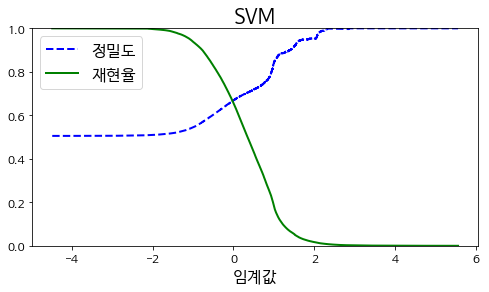

In [68]:
#코스피200 전체 결정경계(SVM)
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores2)
plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.title('SVM',fontsize=20)
plt.show()

In [58]:
score_list6.loc['000670']

LR     0.916149
DT     0.807453
SVM    0.900621
Name: 000670, dtype: float64

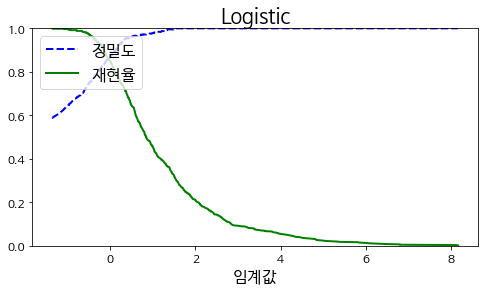

In [82]:
#영풍 결정경계(로지스틱)
X_train_YP = train6["000670"].values
y_train_YP = train_idx6["000670"].values
score1_YP=cross_val_predict(log_clf, X_train_YP, y_train_YP, cv=3,method="decision_function")
score2_YP=cross_val_predict(svm_clf, X_train_YP, y_train_YP, cv=3,method="decision_function")
score3_YP=cross_val_predict(DTC_clf, X_train_YP, y_train_YP, cv=3,method="predict_proba")

precisions, recalls, thresholds = precision_recall_curve(y_train_YP, score1_YP)
plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.title('Logistic',fontsize=20)
plt.show()

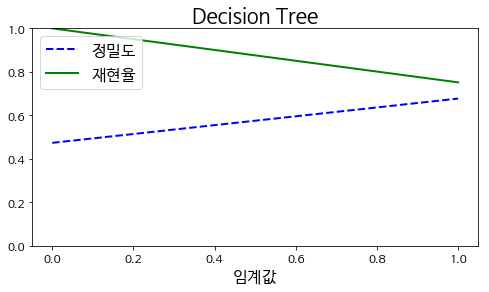

In [162]:
precisions, recalls, thresholds = precision_recall_curve(y_train_YP, score3_YP[:,1])
plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.title('Decision Tree',fontsize=20)
plt.show()

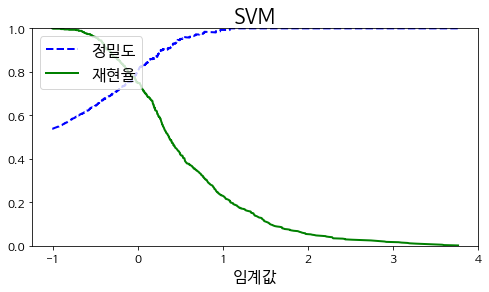

In [61]:
#영풍 결정경계(SVM)
precisions, recalls, thresholds = precision_recall_curve(y_train_YP, score2_YP)
plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.title('SVM',fontsize=20)
plt.show()

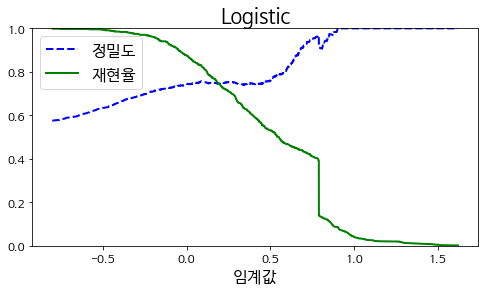

In [77]:
#대우조선해양 결정경계(로지스틱)
X_train_DW = train6["042660"].values
y_train_DW = train_idx6["042660"].values
score1_DW=cross_val_predict(log_clf, X_train_DW, y_train_DW, cv=3,method="decision_function")
score2_DW=cross_val_predict(svm_clf, X_train_DW, y_train_DW, cv=3,method="decision_function")
score3_DW=cross_val_predict(DTC_clf, X_train_DW, y_train_DW, cv=3,method="predict_proba")

precisions, recalls, thresholds = precision_recall_curve(y_train_DW, score1_DW)
plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.title('Logistic',fontsize=20)
plt.show()

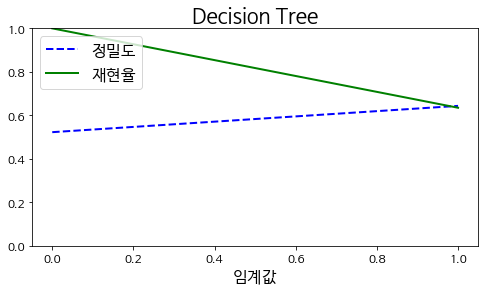

In [163]:
#대우조선해양 결정경계(디시전트리)
precisions, recalls, thresholds = precision_recall_curve(y_train_DW, score3_DW[:,1])
plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.title('Decision Tree',fontsize=20)
plt.show()

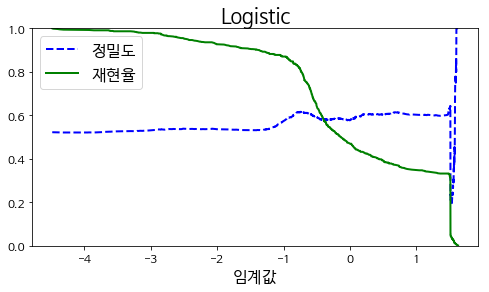

In [63]:
#대우조선해양 결정경계(SVM)
precisions, recalls, thresholds = precision_recall_curve(y_train_DW, score2_DW)
plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.title('Logistic',fontsize=20)
plt.show()

## 정밀도에 대한 재현율 곡선

In [89]:
from sklearn.metrics import precision_recall_curve

def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("재현율", fontsize=16)
    plt.ylabel("정밀도", fontsize=16)
    plt.axis([0, 1, 0, 1])

# 코스피200

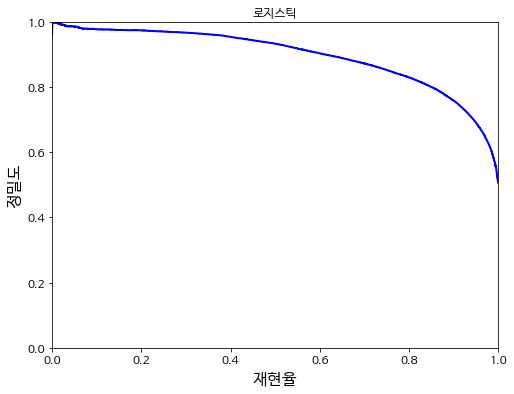

In [92]:
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores1)
plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.title('로지스틱')
plt.show()

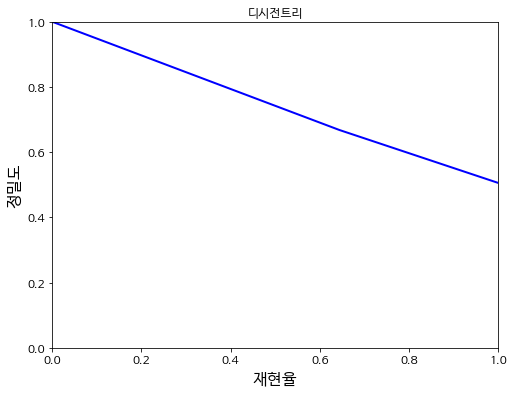

In [94]:
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores3)
plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.title('디시전트리')
plt.show()

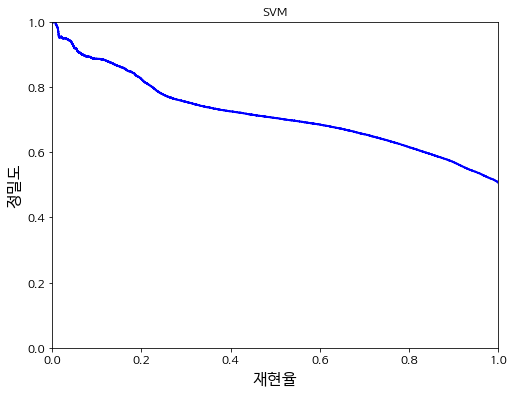

In [96]:
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores2)
plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.title('SVM')
plt.show()

# 영풍

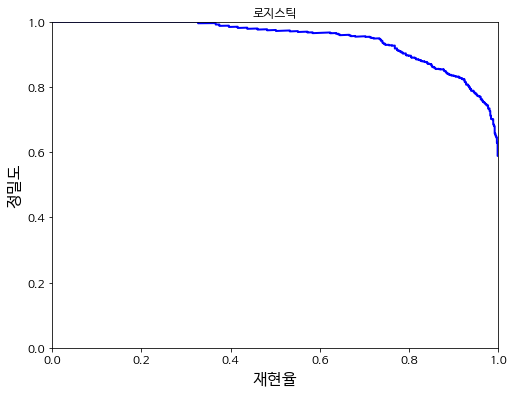

In [99]:
precisions, recalls, thresholds = precision_recall_curve(y_train_YP, score1_YP)
plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.title('로지스틱')
plt.show()

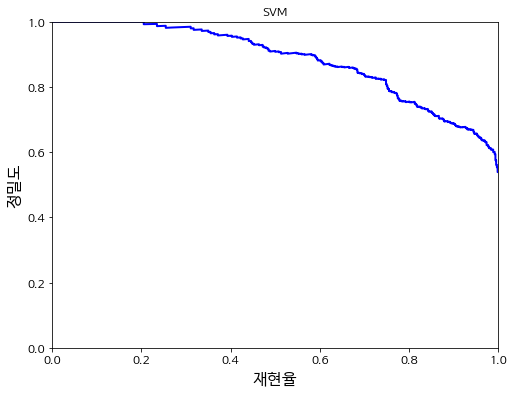

In [98]:
precisions, recalls, thresholds = precision_recall_curve(y_train_YP, score2_YP)
plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.title('SVM')
plt.show()

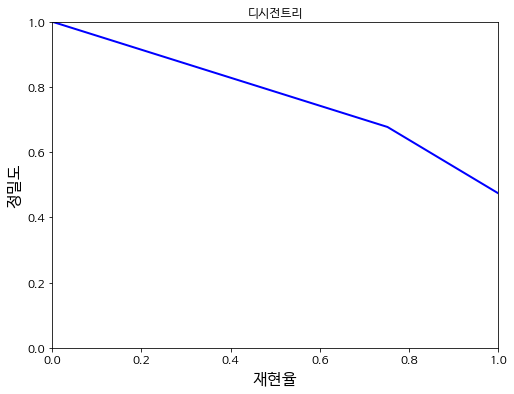

In [101]:
precisions, recalls, thresholds = precision_recall_curve(y_train_YP, score3_YP[:,1])
plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.title('디시전트리')
plt.show()

## ROC 곡선

In [103]:
from sklearn.metrics import roc_curve

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('거짓 양성 비율', fontsize=16)
    plt.ylabel('진짜 양성 비율', fontsize=16)

# 코스피 200

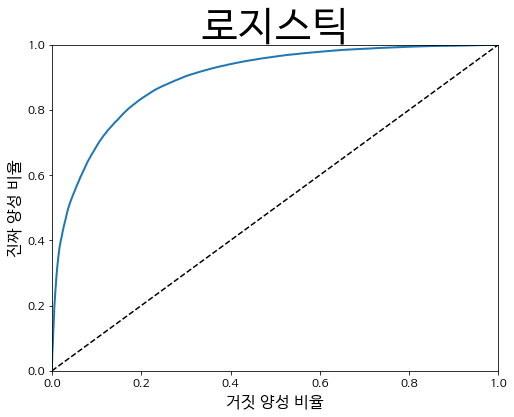

In [107]:
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores1)
plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
plt.title('로지스틱',fontsize=40)
plt.show()

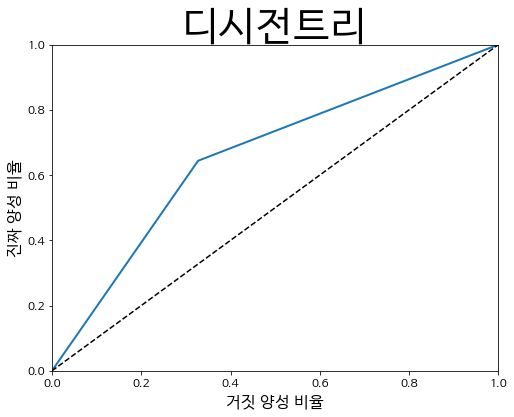

In [118]:
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores3)
plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
plt.title('디시전트리',fontsize=40)
plt.show()

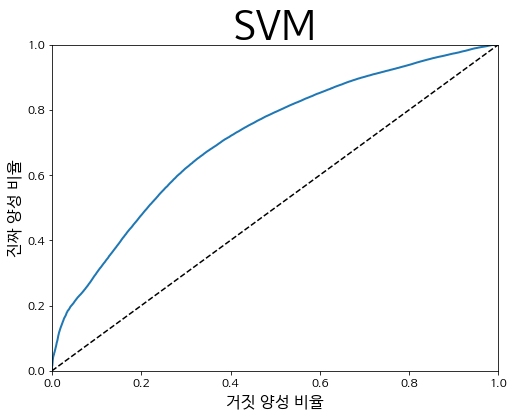

In [117]:
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores2)
plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
plt.title('SVM',fontsize=40)
plt.show()

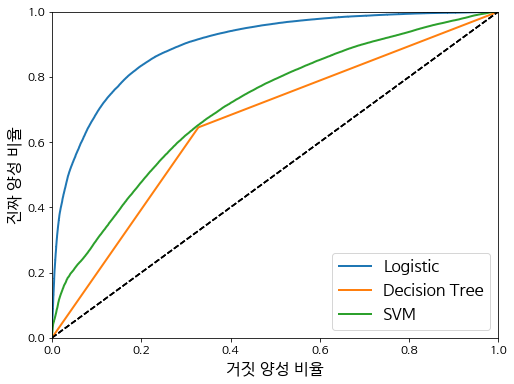

In [160]:
fpr1, tpr1, thresholds1 = roc_curve(y_train_5, y_scores1)
fpr2, tpr2, thresholds2 = roc_curve(y_train_5, y_scores3)
fpr3, tpr3, thresholds3 = roc_curve(y_train_5, y_scores2)
plt.figure(figsize=(8, 6))
plot_roc_curve(fpr1, tpr1,label = 'Logistic')
plot_roc_curve(fpr2, tpr2,label = 'Decision Tree')
plot_roc_curve(fpr3, tpr3,label = 'SVM')
plt.legend(fontsize=16)
plt.show()

In [155]:
from sklearn.metrics import roc_auc_score

print("Logistic",roc_auc_score(y_train_5, y_scores1))
print("Decision Tree",roc_auc_score(y_train_5,y_scores3))
print("SVM",roc_auc_score(y_train_5, y_scores2))

Logistic 0.8967516589785556
Decision Tree 0.6585740908912889
SVM 0.7136920055287743


# 영풍

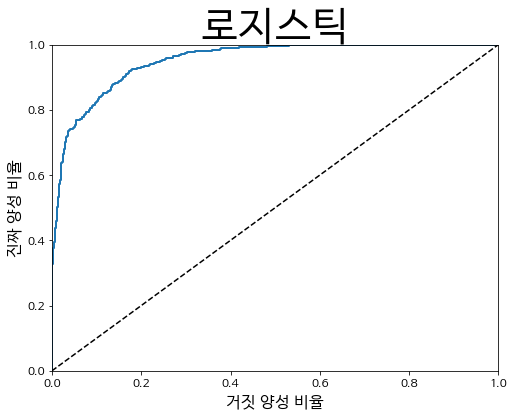

In [112]:
fpr, tpr, thresholds = roc_curve(y_train_YP, score1_YP)
plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
plt.title('로지스틱',fontsize=40)
plt.show()

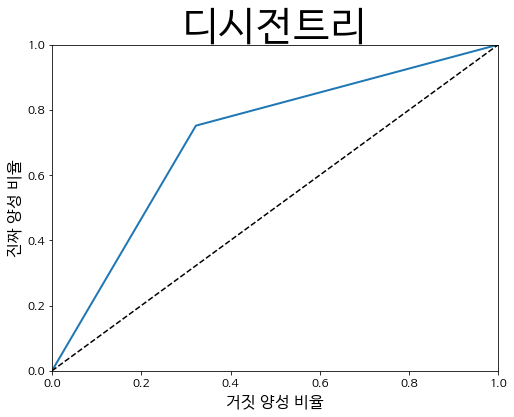

In [115]:
fpr, tpr, thresholds = roc_curve(y_train_YP, score3_YP[:,1])
plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
plt.title('디시전트리',fontsize=40)
plt.show()

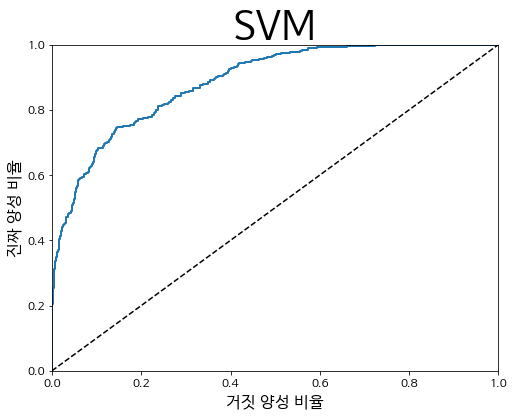

In [116]:
fpr, tpr, thresholds = roc_curve(y_train_YP, score2_YP)
plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
plt.title('SVM',fontsize=40)
plt.show()

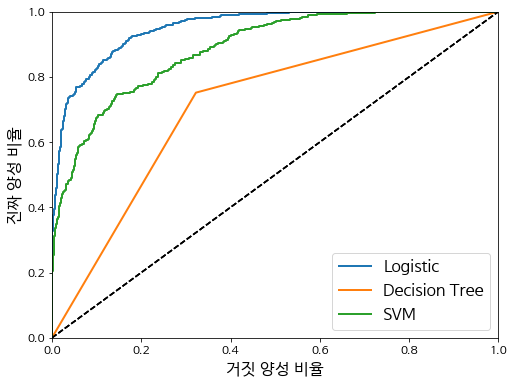

In [156]:
fpr1, tpr1, thresholds1 = roc_curve(y_train_YP, score1_YP)
fpr2, tpr2, thresholds2 = roc_curve(y_train_YP, score3_YP[:,1])
fpr3, tpr3, thresholds3 = roc_curve(y_train_YP, score2_YP)
plt.figure(figsize=(8, 6))
plot_roc_curve(fpr1, tpr1,label = 'Logistic')
plot_roc_curve(fpr2, tpr2,label = 'Decision Tree')
plot_roc_curve(fpr3, tpr3,label = 'SVM')
plt.legend(fontsize=16)
plt.show()

In [157]:
from sklearn.metrics import roc_auc_score

print("Logistic",roc_auc_score(y_train_YP, score1_YP))
print("Decision Tree",roc_auc_score(y_train_YP,score3_YP[:,1]))
print("SVM",roc_auc_score(y_train_YP, score2_YP))

Logistic 0.9510131189660542
Decision Tree 0.7145797648707568
SVM 0.886123871068203


# 대우조선해양

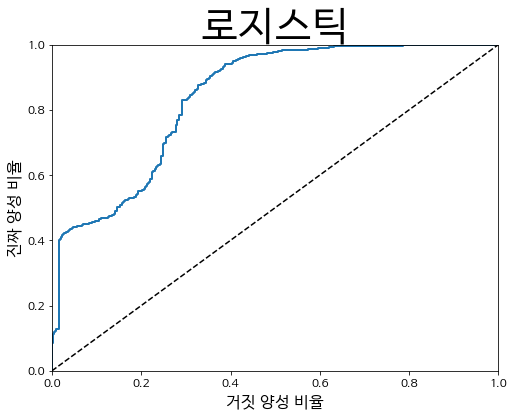

In [119]:
fpr, tpr, thresholds = roc_curve(y_train_DW, score1_DW)
plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
plt.title('로지스틱',fontsize=40)
plt.show()

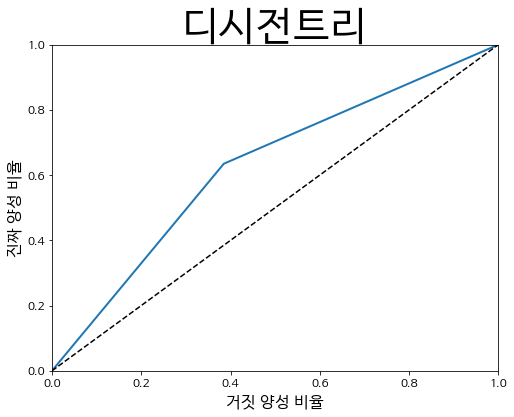

In [121]:
fpr, tpr, thresholds = roc_curve(y_train_DW, score3_DW[:,1])
plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
plt.title('디시전트리',fontsize=40)
plt.show()

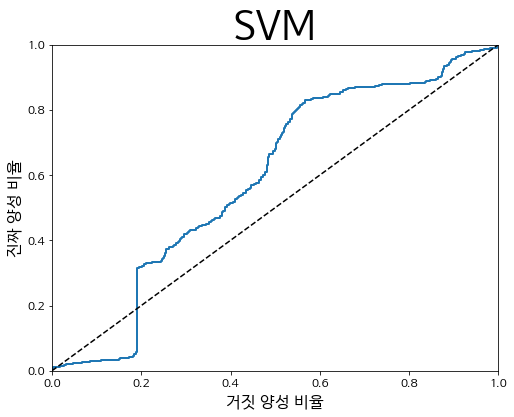

In [122]:
fpr, tpr, thresholds = roc_curve(y_train_DW, score2_DW)
plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
plt.title('SVM',fontsize=40)
plt.show()

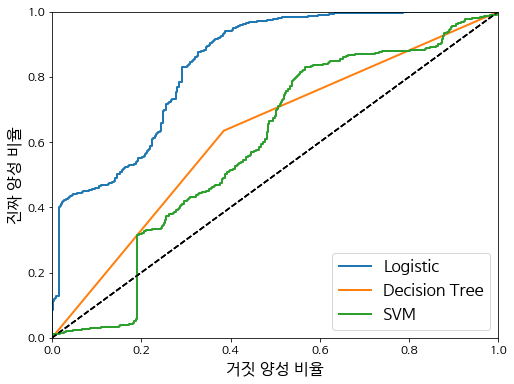

In [158]:
fpr1, tpr1, thresholds1 = roc_curve(y_train_DW, score1_DW)
fpr2, tpr2, thresholds2 = roc_curve(y_train_DW, score3_DW[:,1])
fpr3, tpr3, thresholds3 = roc_curve(y_train_DW, score2_DW)
plt.figure(figsize=(8, 6))
plot_roc_curve(fpr1, tpr1,label = 'Logistic')
plot_roc_curve(fpr2, tpr2,label = 'Decision Tree')
plot_roc_curve(fpr3, tpr3,label = 'SVM')
plt.legend(fontsize=16)
plt.show()

In [159]:
from sklearn.metrics import roc_auc_score

print("Logistic",roc_auc_score(y_train_DW, score1_DW))
print("Decision Tree",roc_auc_score(y_train_DW, score3_DW[:,1]))
print("SVM",roc_auc_score(y_train_DW, score2_DW))

Logistic 0.8402690829348226
Decision Tree 0.6249407400023825
SVM 0.5878834881589408
